# **Machine Learning: Project Part 2**

---

**Author: Damien Farrell**

---

## **Project Part 2: Seal Call Discrimination**

### **Objective**
The aim of this project is to analyze a recorded dataset to investigate the feasibility of discriminating between different seal calls. The project is structured in steps to build a machine learning model that can potentially detect seal calls from audio recordings. While creating a fully functional detector is the ultimate goal, it may not be the final outcome of this project.

#### **Step A: Data Pre-processing**

This step is completed in notebook `data_preprocessing.ipynb`. The file `processed_data.pkl` was produced from this notebook.

#### **Step B: Model Training**
1. **Dataset Utilisation**:
   - Use the prepared spectrogram dataset to train the machine learning model.

3. **Evaluation**:
   - Test the model’s performance on a separate test dataset.

#### **Step C: Refine**
1. **Parameter Tuning**:
   - Adjust parameters in the data extraction/spectrogram creation process (e.g., `nfft`, `noverlap`).
   - Manage computational costs by splitting `.wav` files using tools like `pydub`.

2. **Validation**:
   - Apply the Rupe B/No Call classifier on an entire `.wav` file (held back during training).
   - Ensure no false positives due to the presence of other annotated calls.

In [545]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

---

### **Step B: Model Training** 

---

In [546]:
# Load in processed data
df = pd.read_pickle('processed_data.pkl')
df.head()

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,file_name,folder_name,snippet_spectrogram,snippet_times,snippet_frequencies
0,1,Spectrogram 1,1,4.136987,4.657535,173.956,286.792,0.5205,112.836,-82.85,G Rupe,5711.211013040024,Guttural rupe,"[[10.569122314453125, 4.712647438049316, 1.273...","[4.131708333333333, 4.1445, 4.157291666666667,...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
1,2,Spectrogram 1,1,3.789955,4.264841,371.419,451.345,0.4749,79.926,-92.16,G Rupe,5711.211013040024,Guttural rupe,"[[42.39829635620117, 55.68126678466797, 83.361...","[3.7863333333333333, 3.799125, 3.8119166666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
2,3,Spectrogram 1,1,14.840188,15.406398,136.660,445.248,0.5662,308.588,-88.96,G Rupe,5711.211013040024,Guttural rupe,"[[29.341825485229492, 8.032623291015625, 43.69...","[14.838333333333333, 14.851125, 14.86391666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
3,4,Spectrogram 1,1,24.543802,25.082615,167.519,392.347,0.5388,224.828,-86.10,G Rupe,5711.211013040024,Guttural rupe,"[[0.28541040420532227, 0.41072168946266174, 2....","[24.547208333333334, 24.56, 24.572791666666667...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
4,5,Spectrogram 1,1,35.989220,36.573694,119.027,436.431,0.5845,317.405,-80.18,G Rupe,5711.211013040024,Guttural rupe,"[[13.951732635498047, 23.50061798095703, 20.28...","[35.982958333333336, 35.99575, 36.008541666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."


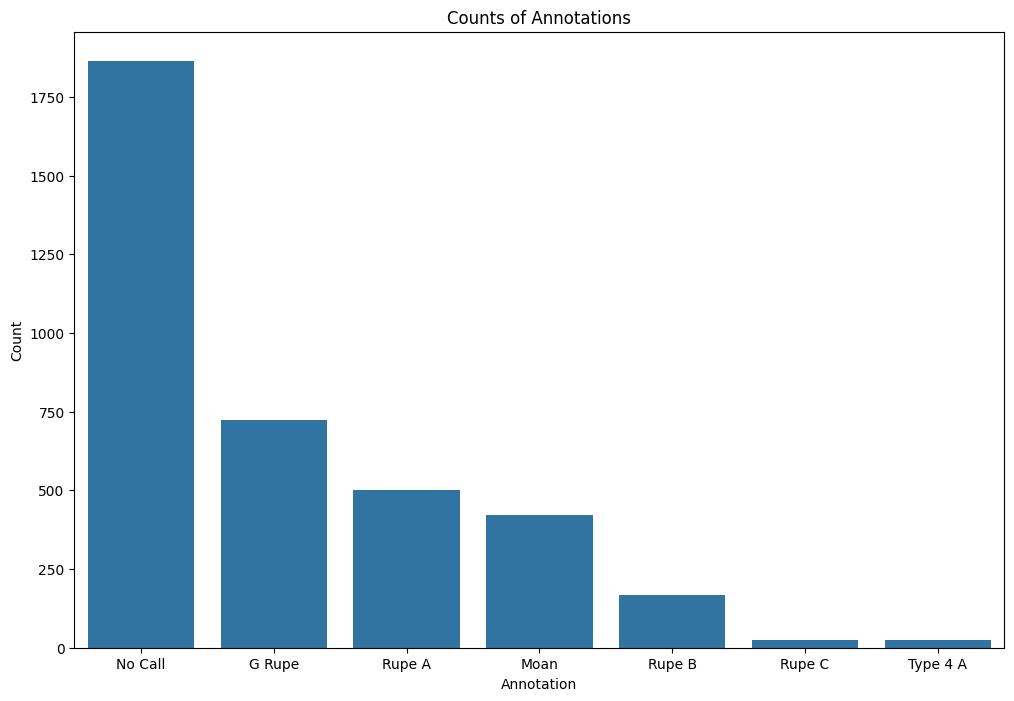

In [547]:
# Count the values
annotation_counts = df['Annotation'].value_counts()

# Create the barplot
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=annotation_counts.index, y=annotation_counts.values, ax=ax)

ax.set_xlabel("Annotation")
ax.set_ylabel("Count")
ax.set_title("Counts of Annotations")
plt.show()

In [548]:
# Perform one-hot encoding
df = pd.get_dummies(df, columns=['Annotation'], prefix='Annotation')

In [549]:
# Get the shapes
shapes = df['snippet_spectrogram'].apply(lambda x: x.shape if isinstance(x, np.ndarray) else None)

# Count unique shapes
print("Unique shapes in 'snippet_spectrogram':")
print(shapes.value_counts())

Unique shapes in 'snippet_spectrogram':
snippet_spectrogram
(42, 84)    3728
Name: count, dtype: int64


In [550]:
X = df[['snippet_spectrogram']].to_numpy()

# "Flatten" the (3742, 1) array to (3742,)
X = X.ravel()
print(X.shape)

# Stack along a new axis to get shape (3742, 42, 84)
X = np.stack(X, axis=0)
print(X.shape)


(3728,)
(3728, 42, 84)


In [551]:
# Reshape to 2D for MinMaxScaler
X_reshaped = X.reshape(-1, X.shape[-2])  # Shape: (3742 * 42, 84)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape back to the original shape
X = X_scaled.reshape(X.shape)

X.shape

(3728, 42, 84)

In [552]:
from sklearn.model_selection import train_test_split

X = np.stack(df['snippet_spectrogram'].values)
y = df[[col for col in df.columns if col.startswith("Annotation_")]]  # Select annotation columns

# `y` contains one-hot encoded labels
stratify_labels = y.idxmax(axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=stratify_labels,
    shuffle=True,
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (2982, 42, 84) Test shape: (746, 42, 84)


In [553]:
stratify_labels

0        Annotation_G Rupe
1        Annotation_G Rupe
2        Annotation_G Rupe
3        Annotation_G Rupe
4        Annotation_G Rupe
               ...        
3723    Annotation_No Call
3724    Annotation_No Call
3725    Annotation_No Call
3726    Annotation_No Call
3727    Annotation_No Call
Length: 3728, dtype: object

In [554]:
# Define focal loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred)
        return K.mean(loss, axis=-1)
    return focal_loss_fixed

In [555]:
num_classes = len(stratify_labels.unique())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(42, 84, 1)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))


In [556]:
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_67 (Conv2D)              │ (None, 42, 84, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 21, 42, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 21, 42, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 10, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 10, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 5, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,927 (1.66 MB)

 Trainable params: 433,927 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [557]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss= focal_loss(gamma=2., alpha=0.25),  #from_logits=False as softmax is on the output of the CNN
    metrics=['accuracy'],
    
)

In [558]:
# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [559]:
# history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks = [callback])

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6137 - loss: 0.0361 - val_accuracy: 0.6801 - val_loss: 0.0245
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7551 - loss: 0.0181 - val_accuracy: 0.8040 - val_loss: 0.0136
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8308 - loss: 0.0117 - val_accuracy: 0.8375 - val_loss: 0.0133
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8684 - loss: 0.0097 - val_accuracy: 0.8727 - val_loss: 0.0121
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8848 - loss: 0.0088 - val_accuracy: 0.8777 - val_loss: 0.0111
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8890 - loss: 0.0097 - val_accuracy: 0.8844 - val_loss: 0.0117
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8936 - loss: 0.0077 - val_accuracy: 0.8794 - val_loss: 0.0124
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9040 - loss: 0.0077 - val_accuracy: 0.8760 - val_loss:

In [560]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8994 - loss: 0.0184


{'accuracy': 0.9128686189651489, 'loss': 0.015201425179839134}

In [561]:
def plot_loss(history, which='loss'):
    plt.plot(history.history[which], label='train')
    try:
        plt.plot(history.history['val_'+which], label='validation')
    except:
        None
    plt.xlabel('Epoch')
    plt.ylabel(which)
    plt.legend()
    plt.grid(True)

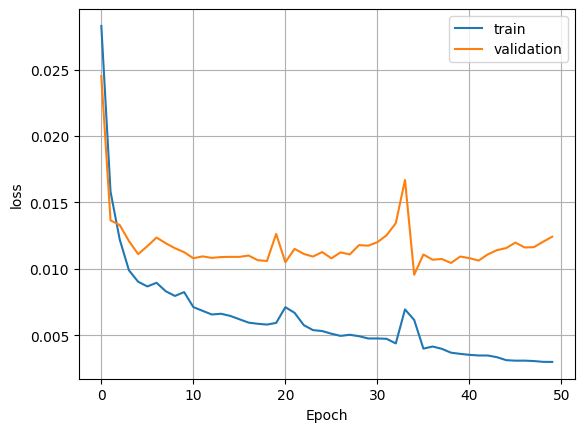

In [562]:
plot_loss(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


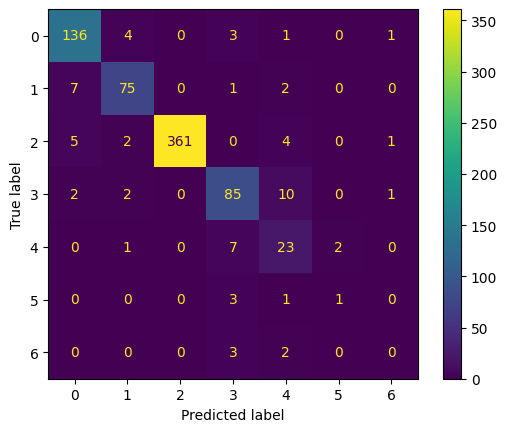

In [563]:
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert to class labels

# Convert y_test from one-hot to class labels
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(y_test.shape[1]))
disp.plot(cmap='viridis')

In [564]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  #from_logits=False as softmax is on the output of the CNN
    metrics = [
    'accuracy',
    tf.keras.metrics.Precision(thresholds=0.5, name="precision"),
    tf.keras.metrics.Recall(thresholds=0.5, name="recall"),
    tf.keras.metrics.F1Score(threshold=0.5, average='macro', name="f1_score"),
]
)

In [569]:
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9999 - f1_score: 0.9969 - loss: 0.0050 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.9330 - val_f1_score: 0.6214 - val_loss: 519.1270 - val_precision: 0.9376 - val_recall: 0.9313
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9992 - f1_score: 0.9635 - loss: 0.0068 - precision: 0.9992 - recall: 0.9989 - val_accuracy: 0.9363 - val_f1_score: 0.6273 - val_loss: 512.2010 - val_precision: 0.9424 - val_recall: 0.9313
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9990 - f1_score: 0.9538 - loss: 0.0060 - precision: 0.9990 - recall: 0.9990 - val_accuracy: 0.9330 - val_f1_score: 0.6178 - val_loss: 536.5741 - val_precision: 0.9330 - val_recall: 0.9330
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9989 - f1_score: 0.9885 - loss: 0.0069 - precision: 0.9989 - recall: 0.9989 - val_accuracy: 0.9229 - val_f1_score: 0.6075 - val_loss: 499.3355 - val_precision: 0.9259 - val_recall:

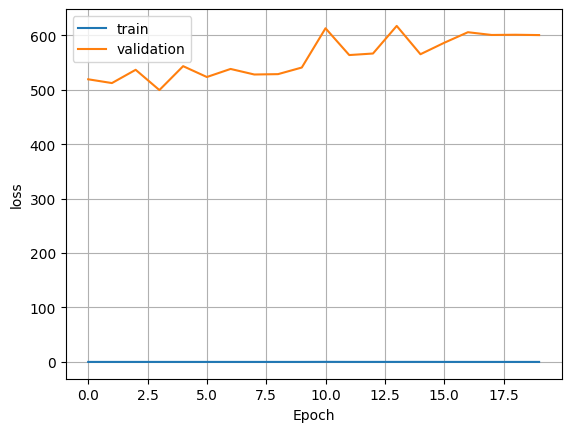

In [570]:
plot_loss(history)

In [571]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9117 - f1_score: 0.6062 - loss: 144.9729 - precision: 0.9145 - recall: 0.9111


{'accuracy': 0.9276139140129089,
 'f1_score': 0.6466860175132751,
 'loss': 216.4634246826172,
 'precision': 0.9300134778022766,
 'recall': 0.9262734651565552}

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


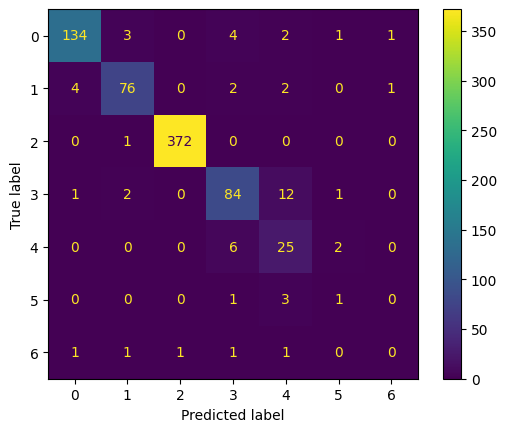

In [572]:
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert to class labels

# Convert y_test from one-hot to class labels
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(y_test.shape[1]))
disp.plot(cmap='viridis')

---

### **Step C: Refine**

---

---

### **References**

1. [Bird Song Dataset on Kaggle](https://www.kaggle.com/code/sophiagnetneva/cnn-for-sound-classification-bird-calls-90)





---

# END